In [12]:
# Import necessary libraries
import cv2
import pytesseract
import numpy as np
from PIL import Image
import io
import matplotlib.pyplot as plt

In [13]:
def preprocess_image(image):
    if len(image.shape) == 2:  # Grayscale image
        gray = image
    elif len(image.shape) == 3 and image.shape[2] == 3:  # BGR image
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 3 and image.shape[2] == 4:  # BGRA image
        gray = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)
    else:
        raise ValueError("Unsupported image format")

    # Apply adaptive thresholding instead of simple blurring
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Try CLAHE (Contrast Limited Adaptive Histogram Equalization) instead of simple equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(blurred)
    
    # Bilateral filter preserves edges while removing noise
    bilateral = cv2.bilateralFilter(enhanced, 11, 17, 17)
    
    # Edge detection
    edged = cv2.Canny(bilateral, 30, 200)
    
    # Use morphological operations to close gaps in edges
    kernel = np.ones((3, 3), np.uint8)
    edged = cv2.dilate(edged, kernel, iterations=1)
    
    return edged

In [14]:
def find_plate_contour(edged, image):
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area, largest first
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    plate_contour = None
    plate_image = None
    max_score = 0
    
    for contour in contours:
        # Approximate the contour
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        
        # Check if it has 4 corners (like a rectangle)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            
            # Calculate aspect ratio of the contour
            aspect_ratio = float(w) / h
            
            # Most license plates have aspect ratio between 2 and 5
            if 1.5 <= aspect_ratio <= 5.5:
                # Calculate contour area and use it as part of scoring
                area = cv2.contourArea(contour)
                area_score = area / (image.shape[0] * image.shape[1])  # Normalized area
                
                # Calculate how rectangular the shape is
                rect_area = w * h
                extent = float(area) / rect_area
                
                # Calculate score based on aspect ratio and rectangularity
                score = extent * (1 - abs((aspect_ratio - 3.5) / 2))  # 3.5 is ideal aspect ratio
                
                if score > max_score:
                    max_score = score
                    plate_contour = approx
                    plate_image = image[y:y+h, x:x+w]
    
    return plate_image

In [15]:
def extract_number_plate_text(plate_image):
    if plate_image is None:
        return "Number plate not detected"
    
    # Convert to grayscale if not already
    if len(plate_image.shape) == 3:
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = plate_image
    
    # Resize for better OCR if plate is too small
    height, width = gray.shape
    if height < 50:
        scale_factor = 50 / height
        gray = cv2.resize(gray, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
    
    # Apply multiple preprocessing techniques and combine results
    results = []
    
    # Method 1: Adaptive threshold
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    kernel = np.ones((1, 1), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    text1 = pytesseract.image_to_string(
        thresh, config='--psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    results.append(text1.strip())
    
    # Method 2: Otsu's thresholding
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    text2 = pytesseract.image_to_string(
        otsu, config='--psm 8 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    results.append(text2.strip())
    
    # Method 3: Original image with different PSM
    text3 = pytesseract.image_to_string(
        gray, config='--psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
    results.append(text3.strip())
    
    # Choose the result with the most alphanumeric characters
    final_text = max(results, key=lambda x: sum(c.isalnum() for c in x))
    
    return final_text.strip()

In [16]:
def process_image(image_path):
    # Read the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to read image from {image_path}")
        return None, None, None, None
    
    # Convert BGR to RGB for display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Process the image
    edged = preprocess_image(image)
    plate_image = find_plate_contour(edged, image)
    
    # Convert plate image to RGB if it exists
    plate_rgb = None
    if plate_image is not None:
        plate_rgb = cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)
        
    # Extract text
    text = extract_number_plate_text(plate_image)
    
    return image_rgb, edged, plate_rgb, text

In [17]:
def display_results(image_path):
    image, edged, plate, text = process_image(image_path)
    
    if image is None:
        print("No image to display")
        return
    
    plt.figure(figsize=(15, 10))
    
    # Display original image
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    # Display edge detection
    plt.subplot(2, 2, 2)
    plt.title("Edge Detection")
    plt.imshow(edged, cmap='gray')
    plt.axis('off')
    
    # Display detected plate if available
    plt.subplot(2, 2, 3)
    if plate is not None:
        plt.title("License Plate")
        plt.imshow(plate)
    else:
        plt.title("No License Plate Detected")
    plt.axis('off')
    
    # Display extracted text
    plt.subplot(2, 2, 4)
    plt.title("Extracted Text")
    plt.text(0.5, 0.5, text, fontsize=20, ha='center')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    print(f"Extracted number plate: {text}")

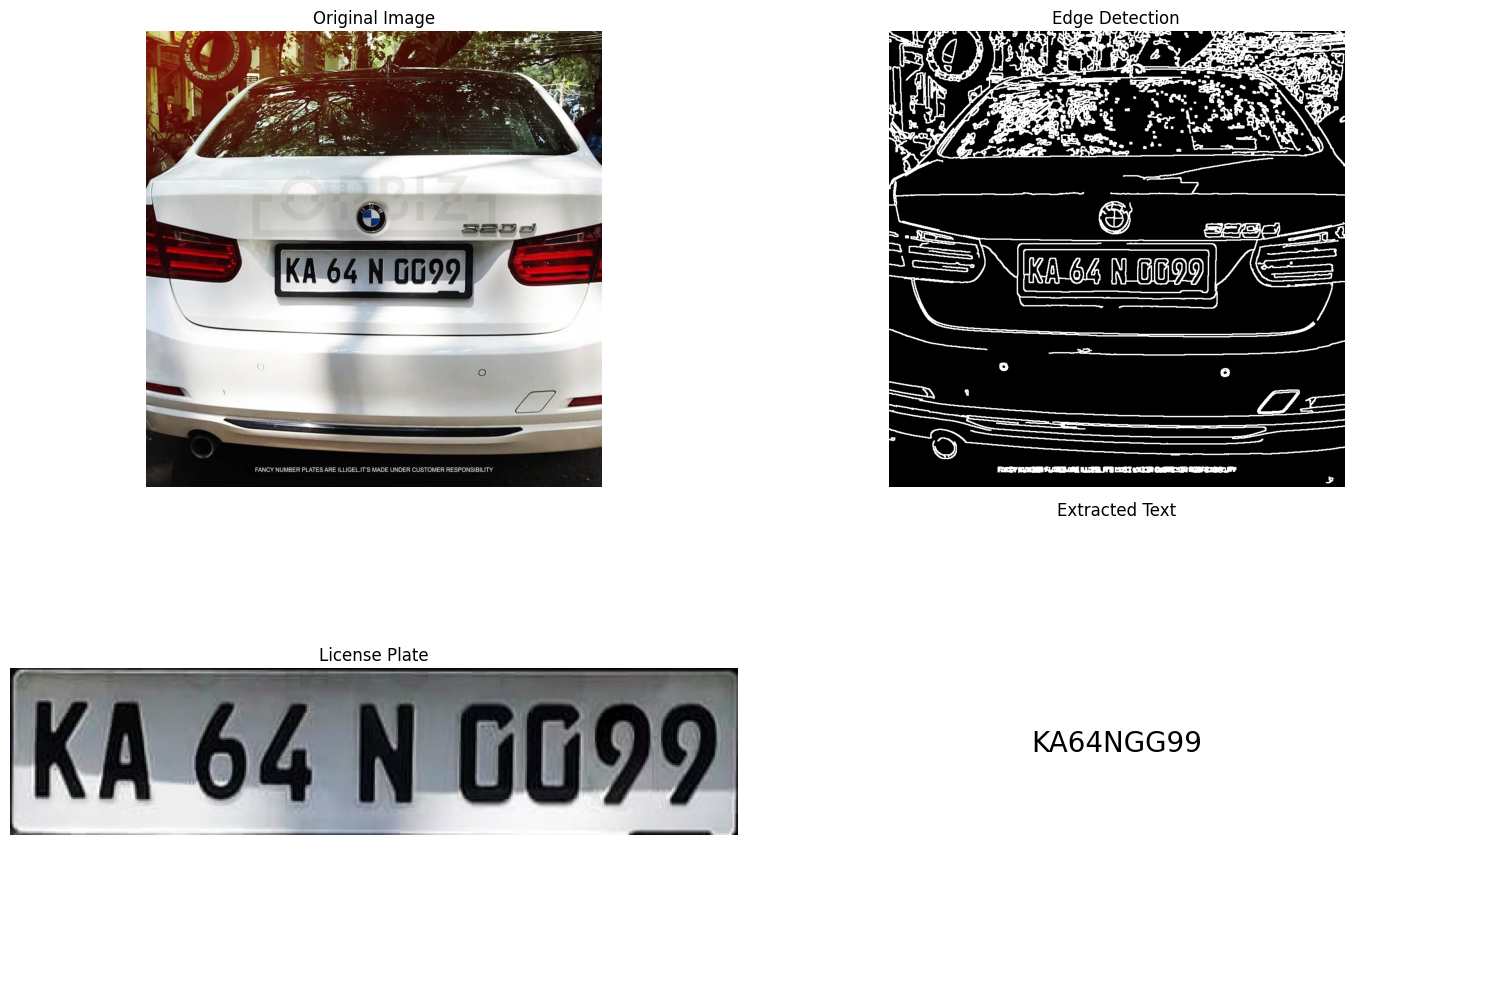

Extracted number plate: KA64NGG99


In [18]:
# Replace with the path to your image
image_path = 'dataset1/number plates/9.png'
display_results(image_path)

Experimental features below

In [19]:
# Only run this in an interactive Jupyter environment
try:
    from ipywidgets import widgets
    from IPython.display import display, clear_output
    
    def process_uploaded_file(change):
        if change['type'] == 'change' and change['name'] == 'value' and change['new']:
            clear_output(wait=True)
            display(upload)
            
            # Read the uploaded file
            image_bytes = upload.value
            image_array = np.frombuffer(image_bytes, dtype=np.uint8)
            img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            
            # Convert from BGR to RGB for display
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Process the image
            edged = preprocess_image(img)
            plate_image = find_plate_contour(edged, img)
            text = extract_number_plate_text(plate_image)
            
            # Convert plate image to RGB if it exists
            plate_rgb = None
            if plate_image is not None:
                plate_rgb = cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 10))
            
            # Display original image
            plt.subplot(2, 2, 1)
            plt.title("Original Image")
            plt.imshow(img_rgb)
            plt.axis('off')
            
            # Display edge detection
            plt.subplot(2, 2, 2)
            plt.title("Edge Detection")
            plt.imshow(edged, cmap='gray')
            plt.axis('off')
            
            # Display detected plate if available
            plt.subplot(2, 2, 3)
            if plate_rgb is not None:
                plt.title("License Plate")
                plt.imshow(plate_rgb)
            else:
                plt.title("No License Plate Detected")
            plt.axis('off')
            
            # Display extracted text
            plt.subplot(2, 2, 4)
            plt.title("Extracted Text")
            plt.text(0.5, 0.5, text, fontsize=20, ha='center')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
    
    upload = widgets.FileUpload(accept='.jpg,.jpeg,.png,.webp', multiple=False)
    upload.observe(process_uploaded_file)
    display(upload)
except ImportError:
    print("Interactive widgets not available. Install ipywidgets for this feature.")

Interactive widgets not available. Install ipywidgets for this feature.


In [ ]:
def visualize_and_save(image_path, output_path):
    """Process an image and save the visualization results"""
    image, edged, plate, text = process_image(image_path)
    
    if image is None:
        print("No image to process")
        return
        
    fig = plt.figure(figsize=(15, 10))
    
    # Add all the visualization components
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.title("Edge Detection")
    plt.imshow(edged, cmap='gray')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    if plate is not None:
        plt.title("License Plate")
        plt.imshow(plate)
    else:
        plt.title("No License Plate Detected")
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.title(f"Extracted Text: {text}")
    plt.axis('off')
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"Visualization saved to {output_path}")
    print(f"Detected license plate text: {text}")


# Example usage:
# visualize_and_save('dataset1/number plates/9.png',
#                    'dataset1/number plates/output_visualization.png')

Visualization saved to dataset1/number plates/output_visualization.png
Detected license plate text: KA64NGG99


In [21]:
import os
import glob

def batch_process_images(input_folder, output_folder):
    """Process all images in a folder and save results to output folder"""
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    # Get all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.webp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(input_folder, ext)))
    
    results = {}
    
    # Process each image
    for i, image_path in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {image_path}")
        
        # Get base filename without extension
        base_name = os.path.splitext(os.path.basename(image_path))[0]
        output_path = os.path.join(output_folder, f"{base_name}_results.png")
        
        # Process the image
        image, edged, plate, text = process_image(image_path)
        
        if image is not None:
            # Save visualization
            visualize_and_save(image_path, output_path)
            
            # Store result
            results[image_path] = {
                "detected_text": text,
                "plate_detected": plate is not None,
                "output_path": output_path
            }
    
    return results

# Example usage:
# results = batch_process_images('path/to/images', 'path/to/output')

In [22]:
# Run a simple test with a sample image
# Replace this with an actual image path
# test_image_path = 'dataset1/number plates/9.png'

# if os.path.exists(test_image_path):
#     print("Processing test image...")
#     display_results(test_image_path)
# else:
#     print(f"Test image not found at: {test_image_path}")
#     print("Please specify a valid image path to test the license plate detection")